<a href="https://colab.research.google.com/github/aksufatih/snn-medmnist/blob/main/SNN_MedMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install snntorch
!pip install medmnist

import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import os

import medmnist
from medmnist import INFO, Evaluator
from IPython.display import HTML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 12.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=9a4ec51e8a92892a2a76452188a39592faf97bcdc6dc16071059079ba9694411
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


<ipython-input-1-7e70a12a06ec>:7: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [2]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  

  for step in range(num_steps):
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spike_data = spikegen.rate(data, num_steps=num_steps)
      spk_rec, _ = forward_pass(net, num_steps, spike_data)
      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)
  return acc/total

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
  

In [23]:
data_path = '/content/' #path to the pneumoniamnist.npz file downloaded from github
set_seed(4) 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_flag = 'pneumoniamnist'
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', transform=transforms.ToTensor(), root=data_path)
test_dataset = DataClass(split='test', transform=transforms.ToTensor(), root=data_path)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=4*BATCH_SIZE, shuffle=False)

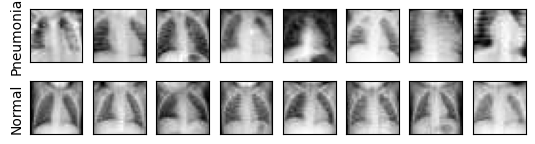

In [4]:
data, label = next(iter(train_loader))
data = data.squeeze()
label = label.squeeze()
ones = np.argwhere(label==1)
zeros = np.argwhere(label==0)

fig, axs = plt.subplots(2,8)
for i in range(8):
  axs[0,i].imshow(data[ones.squeeze()][i], cmap='gray')
  axs[0,i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for i in range(8):
  axs[1,i].imshow(data[zeros.squeeze()][i], cmap='gray')
  axs[1,i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axs[0,0].set_ylabel('Pneumonia')
axs[1,0].set_ylabel('Normal')
plt.subplots_adjust(bottom=0.3, top=0.6, hspace=0)
plt.show()

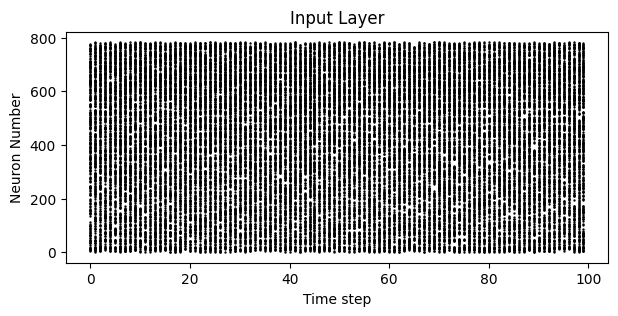

In [5]:
data, label = next(iter(train_loader))
spike_data = spikegen.rate(data[0].squeeze(), num_steps=100)
spike_data = spike_data.reshape((100, -1))
fig = plt.figure(facecolor="w", figsize=(7, 3))
ax = fig.add_subplot(111)
splt.raster(spike_data, ax, s=0.5, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

------- Epoch 0 -------
Train Acc:	59.97%
Test Acc:	57.80%
Epoch loss:	0.693

------- Epoch 1 -------
Train Acc:	74.60%
Test Acc:	68.84%
Epoch loss:	0.689

------- Epoch 2 -------
Train Acc:	79.72%
Test Acc:	76.22%
Epoch loss:	0.678

------- Epoch 3 -------
Train Acc:	74.85%
Test Acc:	67.05%
Epoch loss:	0.649

------- Epoch 4 -------
Train Acc:	80.55%
Test Acc:	78.12%
Epoch loss:	0.603

------- Epoch 5 -------
Train Acc:	83.90%
Test Acc:	79.46%
Epoch loss:	0.555

------- Epoch 6 -------
Train Acc:	86.09%
Test Acc:	79.92%
Epoch loss:	0.520

------- Epoch 7 -------
Train Acc:	85.01%
Test Acc:	78.25%
Epoch loss:	0.503

------- Epoch 8 -------
Train Acc:	86.56%
Test Acc:	78.72%
Epoch loss:	0.492

------- Epoch 9 -------
Train Acc:	86.95%
Test Acc:	79.11%
Epoch loss:	0.480

------- Epoch 10 -------
Train Acc:	86.69%
Test Acc:	79.89%
Epoch loss:	0.471

------- Epoch 11 -------
Train Acc:	86.79%
Test Acc:	78.83%
Epoch loss:	0.470

------- Epoch 12 -------
Train Acc:	86.44%
Test Acc:	80.75%
Ep

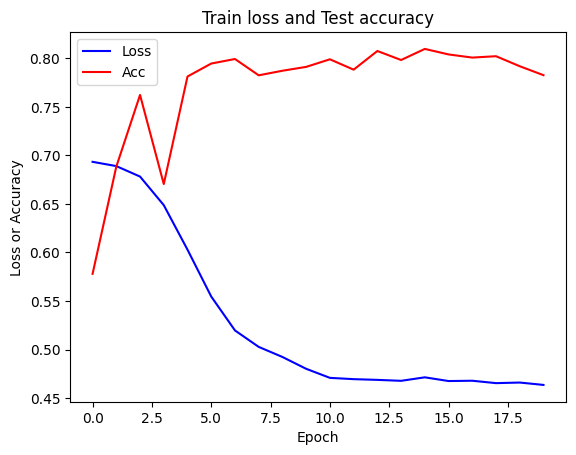

In [6]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.6
num_steps = 20
num_epochs = 20

net = nn.Sequential(nn.Conv2d(1, 12, 5),
                  nn.MaxPool2d(2),
                  snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                  nn.Conv2d(12, 32, 3),
                  nn.MaxPool2d(2),
                  snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                  nn.Flatten(),
                  nn.Linear(32*5*5, 2),
                  snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                  ).to(device)

loss_fn = SF.ce_rate_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

loss_hist = []
test_acc_hist = []

for epoch in range(num_epochs):
    print('-'*7, 'Epoch', epoch, '-'*7)
    epoch_loss = 0
    counter = 0

    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.squeeze().to(device)
        spike_data = spikegen.rate(data, num_steps=num_steps)
        net.train()
        optimizer.zero_grad()
        spk_rec, mem_rec = forward_pass(net, num_steps, spike_data)

        loss = loss_fn(spk_rec, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        counter += 1

    test_acc = batch_accuracy(test_loader, net, num_steps)
    train_acc = batch_accuracy(train_loader_at_eval, net, num_steps)
    print(f"Train Acc:\t{train_acc * 100:.2f}%\nTest Acc:\t{test_acc * 100:.2f}%")
    test_acc_hist.append(test_acc.item())
    print(f'Epoch loss:\t{epoch_loss/counter:.3f}\n')
    loss_hist.append(epoch_loss/counter)
    scheduler.step()

fig = plt.figure(facecolor="w")
plt.plot(loss_hist, c='blue', label='Loss')
plt.plot(test_acc_hist, c='red', label='Acc')
plt.legend()
plt.title("Train loss and Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss or Accuracy")
plt.show()

Ground truth: tensor([1])


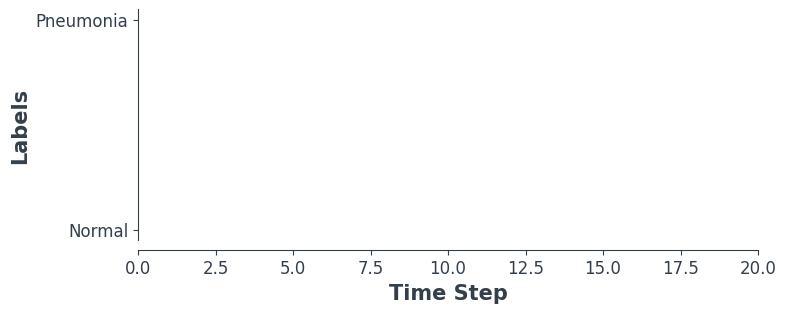

In [17]:
idx = 0
fig, ax = plt.subplots(facecolor='w', figsize=(8, 3))
labels=['Normal', 'Pneumonia']
data, label = next(iter(test_loader))
spike_data = spikegen.rate(data.to(device), num_steps=num_steps)
net.eval()
spk_rec, _ = forward_pass(net, num_steps, spike_data)
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)
print(f'Ground truth: {label[0]}')
HTML(anim.to_html5_video())

In [35]:
from sklearn.metrics import confusion_matrix
with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    spike_data = spikegen.rate(data, num_steps=num_steps)
    spk_rec, _ = forward_pass(net, num_steps, spike_data)
    preds = torch.argmax(spk_rec.sum(dim=0),dim=1)
tn, fp, fn, tp = confusion_matrix(targets.cpu(), preds.cpu()).ravel()
eps = 1e-15
acc = (tp+tn)/(tp+tn+fp+fn)
sensitivity = tp/(tp+fn+eps)
specificity = tn/(tn+fp+eps)
precision = tp/(tp+fp+eps)
recall = sensitivity
f1 = 2*precision*recall/(precision+recall+eps)
gmean = np.sqrt(sensitivity*specificity)

print(f'Accuracy: {acc:.3f}\nSensitivity: {sensitivity:.3f}\nSpecificity: {specificity:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1: {f1:.3f}\nGmean: {gmean:.3f}')

Accuracy: 0.853
Sensitivity: 0.880
Specificity: 0.825
Precision: 0.834
Recall: 0.880
F1: 0.857
Gmean: 0.852
